# Module 12: At-Scale Data Development Tools

## Topic 1: Threading/Multiprocessing Overview and Differences

### Overall simplest way to know when to use each:
### Threading can be used when you are network bound
### Multiprocessing can be used when you are CPU bound

### Threading

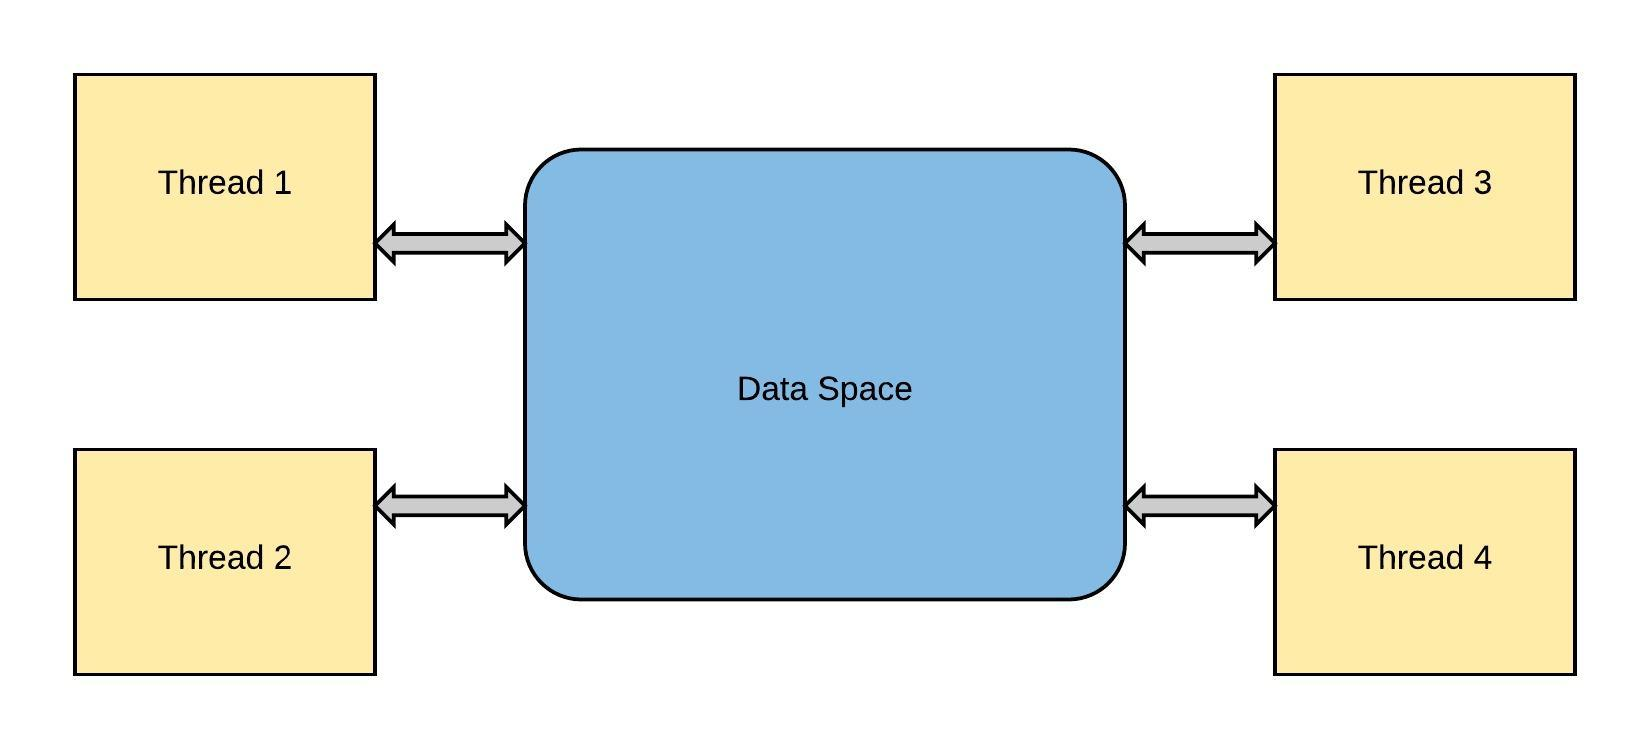

### When you have processes that have a lot of wait time like web scraping multiple pages or multiple API calls, threading can parallelize the processing to speed it up.

## Topic 2: Threading

In [1]:
import threading
from queue import Queue
import time

### In this example, I'll create 5 threads that each print a number sent to them.

In [2]:
import threading
import time

def testThread(num):
    print(num)

if __name__ == '__main__':
    for i in range(5):
        t = threading.Thread(target=testThread, args=(i,))
        t.start()

01
2

3
4


In [3]:
import threading
def print_the_thing(thing):
    print(thing, end=" ")
    
my_sentence = ["I","want","this","to","end","up", "looking", "like", "a", "nice", "sentence"]
for x in my_sentence:
    thread = threading.Thread(target=print_the_thing, args=(x,))
    thread.start()

Iwant  thisto end  up looking likea nice  sentence 

### I can add locks to actions I want to protect

In [4]:
import threading
print_lock = threading.Lock()

def thread_locker(my_word):
    with print_lock:
        print(my_word, end=" ")

my_sentence = ["I","want","this","to","end","up", "looking", "like", "a", "nice", "sentence"]
for x in my_sentence:
    thread = threading.Thread(target=thread_locker, args=(x,))
    thread.start()

I want this to end up looking like a nice sentence 

### Remember our API calls to the Starlink endpoint a few weeks ago?  Let's set up our multiple call again and time it.  I'm going to make 50 calls instead of 25 this time.

In [5]:
import json
import requests

response = requests.get("https://api.spacexdata.com/v4/starlink")

pythoned_json = json.loads(response.text)

starlink_ids = []
for item in pythoned_json:
    if item['id']:
        starlink_ids.append(item['id'])

response_onesat = requests.get(f"https://api.spacexdata.com/v4/starlink/{starlink_ids[0]}")

In [7]:
starlink_ids_small = starlink_ids[0:50] # Limiting to not make too many calls to the API
print(starlink_ids_small)

['5eed770f096e59000698560d', '5eed770f096e59000698560e', '5eed770f096e59000698560f', '5eed770f096e590006985610', '5eed770f096e590006985611', '5eed770f096e590006985612', '5eed770f096e590006985613', '5eed770f096e590006985614', '5eed770f096e590006985615', '5eed770f096e590006985616', '5eed770f096e590006985617', '5eed770f096e590006985618', '5eed770f096e590006985619', '5eed770f096e59000698561a', '5eed7713096e59000698561b', '5eed7714096e59000698561c', '5eed7714096e59000698561d', '5eed7714096e59000698561e', '5eed7714096e59000698561f', '5eed7714096e590006985620', '5eed7714096e590006985621', '5eed7714096e590006985622', '5eed7714096e590006985623', '5eed7714096e590006985624', '5eed7714096e590006985625', '5eed7714096e590006985626', '5eed7714096e590006985627', '5eed7714096e590006985628', '5eed7714096e590006985629', '5eed7714096e59000698562a', '5eed7714096e59000698562b', '5eed7714096e59000698562c', '5eed7714096e59000698562d', '5eed7714096e59000698562e', '5eed7714096e59000698562f', '5eed7714096e590006

### I'm going to time the original code when running 50 calls in sequence

In [8]:
%%time
sat_info_dict = {}
for ident in starlink_ids_small:
    response_sat_it = requests.get(f"https://api.spacexdata.com/v4/starlink/{ident}")
    #print(response_sat_it)
    if response_sat_it.ok:
        response_sat_it_py = json.loads(response_sat_it.text)
        sat_info_dict[ident] = [response_sat_it_py['spaceTrack']['OBJECT_NAME'],response_sat_it_py['spaceTrack']['LAUNCH_DATE'],response_sat_it_py['spaceTrack']['DECAY_DATE']]
    else:
        print("!!Response Error!!", response_sat_it)   

Wall time: 12.8 s


### Now let's set up the same process but use threading to make many calls simultaneously

In [9]:
print(sat_info_dict)

{'5eed770f096e59000698560d': ['STARLINK-30', '2019-05-24', '2020-10-13'], '5eed770f096e59000698560e': ['STARLINK-74', '2019-05-24', '2020-09-29'], '5eed770f096e59000698560f': ['STARLINK-29', '2019-05-24', '2020-10-13'], '5eed770f096e590006985610': ['STARLINK-76', '2019-05-24', None], '5eed770f096e590006985611': ['STARLINK-23', '2019-05-24', '2020-09-02'], '5eed770f096e590006985612': ['STARLINK-22', '2019-05-24', '2020-08-09'], '5eed770f096e590006985613': ['STARLINK-26', '2019-05-24', None], '5eed770f096e590006985614': ['STARLINK-27', '2019-05-24', '2020-09-26'], '5eed770f096e590006985615': ['STARLINK-58', '2019-05-24', '2020-08-23'], '5eed770f096e590006985616': ['TINTIN A', '2018-02-22', '2020-08-29'], '5eed770f096e590006985617': ['TINTIN B', '2018-02-22', '2020-08-08'], '5eed770f096e590006985618': ['STARLINK-68', '2019-05-24', None], '5eed770f096e590006985619': ['STARLINK-31', '2019-05-24', '2020-10-01'], '5eed770f096e59000698561a': ['STARLINK-28', '2019-05-24', '2020-08-21'], '5eed77

In [10]:
%%time
variable_lock = threading.Lock()
sat_info_dict = {}

def thread_locker(starlink_id):
    response_sat_it = requests.get(f"https://api.spacexdata.com/v4/starlink/{starlink_id}")
    with variable_lock:
        if response_sat_it.ok:
            response_sat_it_py = json.loads(response_sat_it.text)
            sat_info_dict[starlink_id] = [response_sat_it_py['spaceTrack']['OBJECT_NAME'],response_sat_it_py['spaceTrack']['LAUNCH_DATE'],response_sat_it_py['spaceTrack']['DECAY_DATE']]
        else:
            print("!!Response Error!!", response_sat_it) 
            
for ident in starlink_ids_small:
    thread = threading.Thread(target=thread_locker, args=(ident,))
    thread.start()

Wall time: 273 ms


In [11]:
print(sat_info_dict)

{'5eed770f096e590006985611': ['STARLINK-23', '2019-05-24', '2020-09-02'], '5eed770f096e59000698560e': ['STARLINK-74', '2019-05-24', '2020-09-29'], '5eed770f096e59000698560d': ['STARLINK-30', '2019-05-24', '2020-10-13'], '5eed770f096e590006985610': ['STARLINK-76', '2019-05-24', None], '5eed770f096e590006985612': ['STARLINK-22', '2019-05-24', '2020-08-09'], '5eed770f096e59000698560f': ['STARLINK-29', '2019-05-24', '2020-10-13'], '5eed770f096e590006985614': ['STARLINK-27', '2019-05-24', '2020-09-26'], '5eed770f096e590006985613': ['STARLINK-26', '2019-05-24', None], '5eed7713096e59000698561b': ['STARLINK-61', '2019-05-24', None], '5eed770f096e590006985615': ['STARLINK-58', '2019-05-24', '2020-08-23'], '5eed770f096e590006985619': ['STARLINK-31', '2019-05-24', '2020-10-01'], '5eed770f096e590006985617': ['TINTIN B', '2018-02-22', '2020-08-08'], '5eed770f096e590006985616': ['TINTIN A', '2018-02-22', '2020-08-29'], '5eed7714096e590006985621': ['STARLINK-36', '2019-05-24', '2020-09-15'], '5eed77

### That's a significant speed improvement.  When you are thinking about using threading, remember two potential drawbacks:
### Our program has some overhead involving handing the threads which can degrade the performance improvement
### Using threading brings along some program complexity which can make debugging more difficult

## Topic 3: Multiprocessing

### By default, Python will only run on a single processor.  We can use the multiprocessing library to set up running Python instances on our other cores.  
### If we are attempting to process something that has a high CPU usage, we can break up the work between the different instances 

In [12]:
import multiprocessing
def spawn():
  print('test!')

if __name__ == '__main__':
  for i in range(5):
    p = multiprocessing.Process(target=spawn())
    p.start()

test!
test!
test!
test!
test!


In [ ]:
### PASTE THIS INTO PYCHARM ###
# There are challenges when trying to use multiprocessing in Jupyter and Idle
import time
import random
import multiprocessing

def spawn(num):
    #time.sleep(random.random())
    print(num,end=" ")

if __name__ == '__main__':
    jobs = []
    for i in range(25):
        p = multiprocessing.Process(target=spawn,args=(i,))
        jobs.append(p)
        p.start()
        #p.join()
        #p.close()

In [13]:
from time import sleep
from os import getpid
from multiprocessing import Process, Manager
import counter as c


if __name__ == '__main__':
    with Manager() as m:
        d = m.dict()
        p1 = Process(target=c.counter,args=(d,))
        p2 = Process(target=c.counter,args=(d,))
        p1.start()
        p2.start()
        p1.join()
        p2.join()
        print(d)

{24788: 10, 15640: 10}


In [14]:
from time import sleep
from os import getpid
from multiprocessing import Process, Manager
import counter as c


if __name__ == '__main__':
    with Manager() as m:
        d = m.dict()
        for i in range(8):
            i = Process(target=c.counter,args=(d,))
            i.start()
            i.join()
        print(d)

{20632: 10, 15976: 10, 9156: 10, 26520: 10, 21996: 10, 21756: 10, 22656: 10, 19612: 10}


### For my multiprocesses to communicate, I need to use either queues or pipes

### Both a pipe and a queue allow items to be put on one end and received from the other.  A queue allows multiple putters and getters, where a pipe only allows one on each end.
### Pipes are more performant but are not process/thread safe

In [ ]:
### PASTE THIS INTO PYCHARM ###

# YouTube Link: https://www.youtube.com/watch?v=TQx3IfCVvQ0

# We show how to make use of the multiprocessing Queue class to communicate
# between different processes.

from multiprocessing import Process, Queue

def square(numbers, queue):
    for i in numbers:
        queue.put(i*i)

def cube(numbers, queue):
    for i in numbers:
        queue.put(i*i*i)

if __name__ == '__main__':

    numbers = range(5)

    queue = Queue()
    square_process = Process(target=square, args=(numbers, queue))
    cube_process = Process(target=cube, args=(numbers, queue))

    square_process.start()
    cube_process.start()

    square_process.join()
    cube_process.join()

    while not queue.empty():
        print(queue.get())


https://medium.com/@lih.verma/multi-processing-in-python-process-vs-pool-5caf0f67eb2b

### Pools vs. Processes
### Pools - great for spreading a whole bunch of simple work among all your processes
### Processes - great for spreading a small amount of complex work among your processes

### In this pool example, I'm squaring numbers and spreading the work across multiple processors.  I've added a 5 ms wait on each process to show the difference between 4 processors and 12

In [15]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  12


In [17]:
%%time
from multiprocessing import Pool
import workers

#def worker(x):
#    return x*x

if __name__ == '__main__':
    num_processors = mp.cpu_count() 
    p=Pool(processes = num_processors)
    output = p.map(workers.worker,[i for i in range(0,10000)])
    #print(output)

Wall time: 6.75 s
